<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Data-Growth" data-toc-modified-id="Data-Growth-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Growth</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hierarchical Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Normalize-to-reference-conditions" data-toc-modified-id="Normalize-to-reference-conditions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Normalize to reference conditions</a></span></li></ul></div>

<font size="4">This is a template notebook for exploratory analysis on your organism's QC'ed dataset.</font>

In [1]:
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_style('ticks')

# Load data

In [3]:
organism = "Sulfolobus_acidocaldarius"

In [4]:
org_dir = path.join('../data/')
os.listdir(org_dir)

['GO_annotations.csv',
 'ica_runs',
 'multiqc_report.html',
 '.DS_Store',
 'iModulon_table.csv',
 'log_tpm_qc.csv',
 'counts.csv',
 'DF_annot_curated_1.tsv',
 'Sulfolobus_acidocaldarius_2020-08-20.tsv',
 'metadata_qc.csv',
 'eggNOG.annotations',
 'gene_info.tsv',
 'log_tpm_norm.csv',
 'gene_info_curated_Jan_07_2021.tsv',
 'GO_annotations.txt',
 'figures',
 'Sulfolobus_acidocaldarius_curated_2020-08-20.tsv',
 'log_tpm.csv',
 'saci_trn_curated_01_01_2021.tsv',
 'multiqc_stats.tsv',
 'kegg_pathway_enrichments.csv',
 'GO_enrichments.csv',
 'kegg_module_enrichments.csv',
 'kegg_mapping.csv',
 'DF_annot_curated_final.tsv',
 'saci_ica_data.json']

In [5]:
DF_metadata = pd.read_csv(os.path.join(org_dir,'metadata_qc.csv'),index_col=0)
DF_log_tpm = pd.read_csv(os.path.join(org_dir,'log_tpm_qc.csv'),index_col=0)

# Data Growth

In [6]:
DF_metadata['ReleaseDate'] = pd.to_datetime(DF_metadata['ReleaseDate'])

In [7]:
first_date = min(DF_metadata['ReleaseDate'])
last_date = max(DF_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

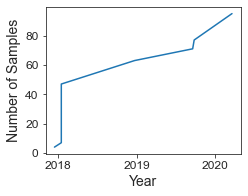

In [8]:
fig,ax = plt.subplots(figsize=(3.5,3))
growth = DF_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax)
plt.xticks(date_range,date_range.strftime('%Y'),rotation=0,ha='center')
ax.tick_params(labelsize=12)
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Number of Samples',fontsize=14)
plt.savefig('../data/figures/data_growth.svg')
plt.show()

# Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [9]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  12


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

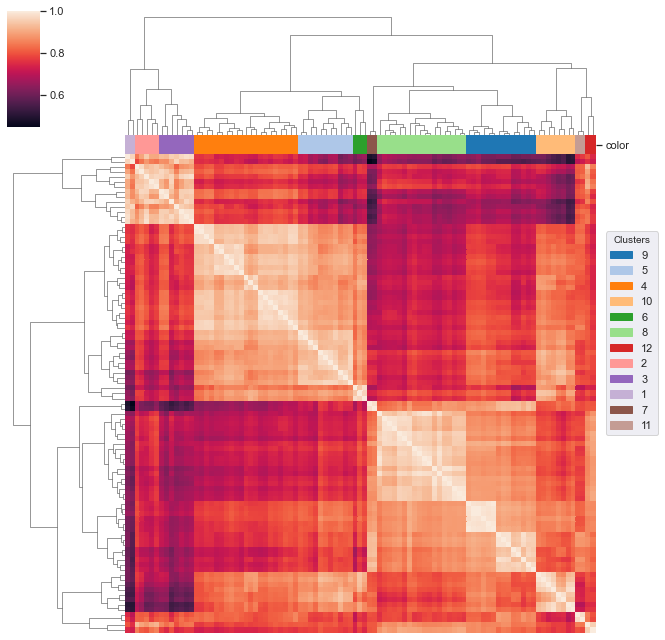

In [10]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

# PCA

In [11]:
from sklearn.decomposition import PCA
import numpy as np

<font size="4"> First compute principal components.</font>

In [12]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(DF_log_tpm.T),index=DF_log_tpm.columns)
DF_components = pd.DataFrame(pca.components_.T,index=DF_log_tpm.index)

<font size="4"> Next, plot the cumulative explained variance</font>

Number of dimensions for 99% of variance: 61


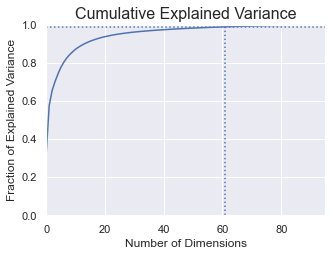

In [13]:
# Set the explained variance threshold
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3.5))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(DF_log_tpm.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(DF_log_tpm.columns))
ax.set_ylabel('Fraction of Explained Variance',fontsize=12)
ax.set_xlabel('Number of Dimensions',fontsize=12)
ax.set_title('Cumulative Explained Variance',fontsize=16)
print('Number of dimensions for 99% of variance:',dims)

<font size="4">Finally, plot the first two principle components. The following code colors data by Project Name.</font>

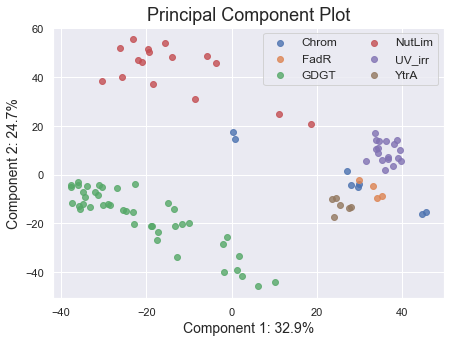

In [14]:
fig,ax = plt.subplots(figsize=(7,5))
for name,group in DF_metadata.groupby('project'):
    idx = DF_log_tpm.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               label=name,alpha=0.8)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100),fontsize=14)
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100),fontsize=14)
ax.set_title('Principal Component Plot',fontsize=18)
plt.legend(bbox_to_anchor=(1,1),fontsize=12,ncol=2)

# Normalize to reference conditions

In [15]:
project_exprs = []
for name,group in DF_metadata.groupby('project'):
    ref_cond = group.reference_condition.unique()
    
    # Ensure that there is only one reference condition per project
    assert(len(ref_cond) == 1)
    ref_cond = ref_cond[0]
    
    # Ensure the reference condition is in fact in the project
    assert(ref_cond in group.condition.tolist())
    
    # Get reference condition sample ids
    ref_samples = group[group.condition == ref_cond].index
    
    # Get reference condition expression
    ref_expr = DF_log_tpm[ref_samples].mean(axis=1)
    
    # Subtract reference expression from project
    project_exprs.append(DF_log_tpm[group.index].sub(ref_expr,axis=0))

DF_log_tpm_norm = pd.concat(project_exprs,axis=1)

In [16]:
DF_log_tpm_norm.head()

,SRX5495523,SRX5495524,SRX5495525,SRX5495526,SRX6762909,SRX6762910,SRX6762911,SRX6762912,SRX3467357,SRX3467358,...,SRX3823536,SRX3823537,SRX3823538,SRX3823539,SRX5653264,SRX5653265,SRX5653266,SRX5653267,SRX5653268,SRX5653269
Geneid,,,,,,,,,,,,,,,,,,,,,
SACI_RS00005,-0.182462,-0.105333,-1.281530,-1.110839,-0.075542,0.075542,-0.269679,-0.110069,0.183304,-0.183304,...,-0.667607,0.462137,0.502872,0.647875,-0.464008,-0.127601,0.063390,0.372230,-0.711439,0.339209
SACI_RS00010,0.073365,-0.068697,-1.310407,-0.905194,-0.226976,0.226976,-0.193518,0.015972,0.091422,-0.091422,...,-1.647438,0.401994,0.373091,-0.056674,-0.493505,-0.061113,0.095582,0.405376,-0.681511,0.276135
SACI_RS00015,-0.293535,-0.079028,0.680194,0.693979,-0.146175,0.146175,-0.426066,-0.062339,-0.138540,0.138540,...,0.113772,0.067428,0.187824,0.063443,-0.078908,-0.203482,-0.142567,-0.064328,0.134443,-0.070115
SACI_RS00020,0.564359,-0.119853,1.177158,1.318188,-0.173191,0.173191,0.371522,0.238799,-0.062844,0.062844,...,-0.007470,0.369845,0.176405,0.087156,-0.136389,-0.107600,-0.027578,0.087341,-0.026054,-0.061288
SACI_RS00025,-0.295610,0.043918,0.342025,0.516124,0.013099,-0.013099,-0.040635,0.018228,0.065332,-0.065332,...,0.733554,0.709455,0.640869,0.453969,-0.199548,-0.118102,-0.098626,-0.078724,0.050906,0.027818


<font size=4>Uncomment this code to save the log_tpm_norm file</font>

In [17]:
DF_log_tpm_norm.to_csv(path.join(org_dir,'log_tpm_norm.csv'))